In [1]:
import tensorflow as tf
from tensorflow.python.keras import models as m
from tensorflow.python.keras import layers as l

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import joblib

In [3]:
from ROOT import TFile, TTree, TChain
print("All classes initialized succesfully.")

Welcome to JupyROOT 6.18/04
All classes initialized succesfully.


In [6]:
sigChan = TChain("varTree")
sigChan.Add("../signal_train.root")
bkgChan = TChain("varTree")
bkgChan.Add("../background_DNN.root")
print("Data read from the trees. Printing out the contents.")

Data read from the trees. Printing out the contents.


In [7]:
sigChan.Print()
bkgChan.Print()

******************************************************************************
*Chain   :varTree   : ../signal_train.root                                   *
******************************************************************************
******************************************************************************
*Tree    :varTree   : Input Variables List for Algorithms                    *
*Entries :    44440 : Total =         3213746 bytes  File  Size =    2732242 *
*        :          : Tree compression factor =   1.17                       *
******************************************************************************
*Br    0 :HtJet     : HtJet/D                                                *
*Entries :    44440 : Total  Size=     356973 bytes  File Size  =      24645 *
*Baskets :       12 : Basket Size=      32000 bytes  Compression=  14.46     *
*............................................................................*
*Br    1 :dRLL      : dRLL/D                        

In [8]:
# Read input data from root files
sigSampleSize = sigChan.GetEntries()
bkgSampleSize = bkgChan.GetEntries()
print(sigSampleSize)
print(bkgSampleSize)

44440
4108


In [9]:
# Convert the input data to matrices
sigFull = sigChan.AsMatrix()
bkgFull = bkgChan.AsMatrix()
print(sigFull[0])
print(sigFull.shape)
print(bkgFull.shape)

[ 0.          2.49833166  0.80792055  3.60755951  4.04035573  0.48130491
  0.32805805  0.29058502 70.49661585]
(44440, 9)
(4108, 9)


In [10]:
# Choose 20% of the data for testing and 80% of the data for training
sigTrain = sigFull[0:int(0.8*sigFull.shape[0])][:]
bkgTrain = bkgFull[0:int(0.8*bkgFull.shape[0])][:]
sigTest = sigFull[int(0.8*sigFull.shape[0]):][:]
bkgTest = bkgFull[int(0.8*bkgFull.shape[0]):][:]
print(sigTrain.shape)
print(bkgTrain.shape)
print(sigTest.shape)
print(bkgTest.shape)

(35552, 9)
(3286, 9)
(8888, 9)
(822, 9)


In [11]:
# Set a scaler for input features
scaler = StandardScaler()
scaler_input = np.concatenate((sigTrain,bkgTrain))
print(scaler.fit(scaler_input))
print(scaler.mean_)
joblib.dump(scaler, "scaler.save")

StandardScaler(copy=True, with_mean=True, with_std=True)
[ 3.26113929  2.85206341  0.71608697  7.10178975  2.41076365  1.64264783
  0.2280836   0.07920158 57.8950444 ]


['scaler.save']

In [12]:
# Build the model
per = m.Sequential()
per.add(l.Dense(18, input_dim=sigTrain.shape[1], activation='relu'))
per.add(l.Dropout(rate=0.2))
per.add(l.Dense(18, activation='relu'))
per.add(l.Dropout(rate=0.2))
per.add(l.Dense(2, activation='softmax'))
print("Model building complete!!!")

per.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

Model building complete!!!


2020-04-20 21:59:35.099684: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA


In [13]:
# Loop to change the training sample every time
# by randomly choosing from the avalaible sample space.
# Make sure to run atleast so that each and every event has been used once.

nShuffleRun = 10
trainingSampleSize = sigTrain.shape[0] if sigTrain.shape[0]<bkgTrain.shape[0] else bkgTrain.shape[0]
testSampleSize = sigTest.shape[0] if sigTest.shape[0]<bkgTest.shape[0] else bkgTest.shape[0]

print(trainingSampleSize)
print(testSampleSize)

3286
822


In [14]:
nEpochs = 100

lossTrain = []
lossTest = []
accTrain = []
accTest = []

for iterTrain in np.arange(nShuffleRun):
    
    sigTrainSampleRange = np.arange(sigTrain.shape[0])
    sigTrainSampleIndex = np.random.choice(sigTrainSampleRange, trainingSampleSize, replace=False)
    sigTrainChosen = sigTrain[sigTrainSampleIndex,:]
    bkgTrainSampleRange = np.arange(bkgTrain.shape[0])
    bkgTrainSampleIndex = np.random.choice(bkgTrainSampleRange, trainingSampleSize, replace=False)
    bkgTrainChosen = bkgTrain[bkgTrainSampleIndex,:]
    
    sigTestSampleRange = np.arange(sigTest.shape[0])
    sigTestSampleIndex = np.random.choice(sigTestSampleRange, testSampleSize, replace=False)
    sigTestChosen = sigTest[sigTestSampleIndex,:]
    bkgTestSampleRange = np.arange(bkgTest.shape[0])
    bkgTestSampleIndex = np.random.choice(bkgTestSampleRange, testSampleSize, replace=False)
    bkgTestChosen = bkgTest[bkgTestSampleIndex,:]
    
    #print(sigTrainChosen.shape)
    #print(bkgTrainChosen.shape)
    
    # Concatenate the signal and background with proper labels
    x = np.concatenate((sigTrainChosen,bkgTrainChosen))
    y = np.matrix([[1,0]]*sigTrainChosen.shape[0]+[[0,1]]*bkgTrainChosen.shape[0])
    x_test = np.concatenate((sigTestChosen,bkgTestChosen))
    y_test = np.matrix([[1,0]]*sigTestChosen.shape[0]+[[0,1]]*bkgTestChosen.shape[0])
    print("Feature Space: ",x.shape)
    
    # Randomize the training samples
    arr = np.arange(x.shape[0])
    np.random.shuffle(arr)
    x = x[arr,:]
    y = y[arr,:]
    
    # Scale the input features
    x = scaler.transform(x)
    x_test = scaler.transform(x_test)
    
    history = per.fit(x, 
                      y, 
                      validation_data=(x_test, y_test), 
                      epochs=nEpochs, 
                      batch_size=int(0.1*x.shape[0]))
    
    lossTrain.extend(history.history['loss'])
    lossTest.extend(history.history['val_loss'])
    accTrain.extend(history.history['accuracy'])
    accTest.extend(history.history['val_accuracy'])


Feature Space:  (6572, 9)
Train on 6572 samples, validate on 1644 samples
Epoch 1/100
6572/6572 [==============================] - 1s 165us/sample - loss: 0.9575 - accuracy: 0.4854 - val_loss: 1.1094 - val_accuracy: 0.4629
Epoch 2/100
6572/6572 [==============================] - 0s 10us/sample - loss: 0.8510 - accuracy: 0.4965 - val_loss: 0.9622 - val_accuracy: 0.5085
Epoch 3/100
6572/6572 [==============================] - 0s 15us/sample - loss: 0.7682 - accuracy: 0.5023 - val_loss: 0.8608 - val_accuracy: 0.5328
Epoch 4/100
6572/6572 [==============================] - 0s 22us/sample - loss: 0.7220 - accuracy: 0.5429 - val_loss: 0.7830 - val_accuracy: 0.5584
Epoch 5/100
6572/6572 [==============================] - 0s 19us/sample - loss: 0.6884 - accuracy: 0.5656 - val_loss: 0.7163 - val_accuracy: 0.6709
Epoch 6/100
6572/6572 [==============================] - 0s 19us/sample - loss: 0.6532 - accuracy: 0.5978 - val_loss: 0.6592 - val_accuracy: 0.6776
Epoch 7/100
6572/6572 [==============

6572/6572 [==============================] - 0s 16us/sample - loss: 0.4210 - accuracy: 0.7934 - val_loss: 0.3817 - val_accuracy: 0.8193
Epoch 56/100
6572/6572 [==============================] - 0s 21us/sample - loss: 0.4234 - accuracy: 0.7943 - val_loss: 0.3804 - val_accuracy: 0.8206
Epoch 57/100
6572/6572 [==============================] - 0s 23us/sample - loss: 0.4203 - accuracy: 0.7972 - val_loss: 0.3787 - val_accuracy: 0.8285
Epoch 58/100
6572/6572 [==============================] - 0s 20us/sample - loss: 0.4158 - accuracy: 0.8001 - val_loss: 0.3773 - val_accuracy: 0.8303
Epoch 59/100
6572/6572 [==============================] - 0s 19us/sample - loss: 0.4169 - accuracy: 0.8005 - val_loss: 0.3775 - val_accuracy: 0.8248
Epoch 60/100
6572/6572 [==============================] - 0s 19us/sample - loss: 0.4128 - accuracy: 0.7996 - val_loss: 0.3776 - val_accuracy: 0.8242
Epoch 61/100
6572/6572 [==============================] - 0s 32us/sample - loss: 0.4087 - accuracy: 0.7981 - val_loss: 

6572/6572 [==============================] - 0s 18us/sample - loss: 0.3836 - accuracy: 0.8173 - val_loss: 0.3595 - val_accuracy: 0.8285
Epoch 10/100
6572/6572 [==============================] - 0s 19us/sample - loss: 0.3807 - accuracy: 0.8200 - val_loss: 0.3585 - val_accuracy: 0.8297
Epoch 11/100
6572/6572 [==============================] - 0s 20us/sample - loss: 0.3809 - accuracy: 0.8198 - val_loss: 0.3585 - val_accuracy: 0.8339
Epoch 12/100
6572/6572 [==============================] - 0s 22us/sample - loss: 0.3790 - accuracy: 0.8163 - val_loss: 0.3583 - val_accuracy: 0.8382
Epoch 13/100
6572/6572 [==============================] - 0s 18us/sample - loss: 0.3733 - accuracy: 0.8208 - val_loss: 0.3589 - val_accuracy: 0.8358
Epoch 14/100
6572/6572 [==============================] - 0s 24us/sample - loss: 0.3712 - accuracy: 0.8252 - val_loss: 0.3582 - val_accuracy: 0.8345
Epoch 15/100
6572/6572 [==============================] - 0s 22us/sample - loss: 0.3756 - accuracy: 0.8230 - val_loss: 

6572/6572 [==============================] - 0s 24us/sample - loss: 0.3633 - accuracy: 0.8288 - val_loss: 0.3486 - val_accuracy: 0.8364
Epoch 65/100
6572/6572 [==============================] - 0s 21us/sample - loss: 0.3650 - accuracy: 0.8291 - val_loss: 0.3482 - val_accuracy: 0.8370
Epoch 66/100
6572/6572 [==============================] - 0s 23us/sample - loss: 0.3655 - accuracy: 0.8290 - val_loss: 0.3482 - val_accuracy: 0.8339
Epoch 67/100
6572/6572 [==============================] - 0s 20us/sample - loss: 0.3611 - accuracy: 0.8293 - val_loss: 0.3482 - val_accuracy: 0.8370
Epoch 68/100
6572/6572 [==============================] - 0s 20us/sample - loss: 0.3618 - accuracy: 0.8363 - val_loss: 0.3476 - val_accuracy: 0.8345
Epoch 69/100
6572/6572 [==============================] - 0s 20us/sample - loss: 0.3598 - accuracy: 0.8285 - val_loss: 0.3472 - val_accuracy: 0.8333
Epoch 70/100
6572/6572 [==============================] - 0s 21us/sample - loss: 0.3612 - accuracy: 0.8259 - val_loss: 

6572/6572 [==============================] - 0s 22us/sample - loss: 0.3546 - accuracy: 0.8309 - val_loss: 0.3433 - val_accuracy: 0.8418
Epoch 19/100
6572/6572 [==============================] - 0s 23us/sample - loss: 0.3573 - accuracy: 0.8271 - val_loss: 0.3415 - val_accuracy: 0.8461
Epoch 20/100
6572/6572 [==============================] - 0s 28us/sample - loss: 0.3547 - accuracy: 0.8258 - val_loss: 0.3396 - val_accuracy: 0.8461
Epoch 21/100
6572/6572 [==============================] - 0s 27us/sample - loss: 0.3615 - accuracy: 0.8305 - val_loss: 0.3398 - val_accuracy: 0.8473
Epoch 22/100
6572/6572 [==============================] - 0s 25us/sample - loss: 0.3546 - accuracy: 0.8326 - val_loss: 0.3385 - val_accuracy: 0.8467
Epoch 23/100
6572/6572 [==============================] - 0s 20us/sample - loss: 0.3526 - accuracy: 0.8348 - val_loss: 0.3371 - val_accuracy: 0.8473
Epoch 24/100
6572/6572 [==============================] - 0s 20us/sample - loss: 0.3531 - accuracy: 0.8334 - val_loss: 

6572/6572 [==============================] - 0s 18us/sample - loss: 0.3524 - accuracy: 0.8314 - val_loss: 0.3318 - val_accuracy: 0.8522
Epoch 74/100
6572/6572 [==============================] - 0s 20us/sample - loss: 0.3478 - accuracy: 0.8351 - val_loss: 0.3306 - val_accuracy: 0.8504
Epoch 75/100
6572/6572 [==============================] - 0s 21us/sample - loss: 0.3509 - accuracy: 0.8341 - val_loss: 0.3302 - val_accuracy: 0.8504
Epoch 76/100
6572/6572 [==============================] - 0s 19us/sample - loss: 0.3481 - accuracy: 0.8370 - val_loss: 0.3303 - val_accuracy: 0.8510
Epoch 77/100
6572/6572 [==============================] - 0s 21us/sample - loss: 0.3490 - accuracy: 0.8314 - val_loss: 0.3302 - val_accuracy: 0.8498
Epoch 78/100
6572/6572 [==============================] - 0s 26us/sample - loss: 0.3453 - accuracy: 0.8361 - val_loss: 0.3302 - val_accuracy: 0.8491
Epoch 79/100
6572/6572 [==============================] - 0s 22us/sample - loss: 0.3486 - accuracy: 0.8367 - val_loss: 

6572/6572 [==============================] - 0s 17us/sample - loss: 0.3487 - accuracy: 0.8386 - val_loss: 0.3295 - val_accuracy: 0.8491
Epoch 28/100
6572/6572 [==============================] - 0s 18us/sample - loss: 0.3489 - accuracy: 0.8338 - val_loss: 0.3309 - val_accuracy: 0.8510
Epoch 29/100
6572/6572 [==============================] - 0s 22us/sample - loss: 0.3463 - accuracy: 0.8354 - val_loss: 0.3294 - val_accuracy: 0.8522
Epoch 30/100
6572/6572 [==============================] - 0s 21us/sample - loss: 0.3459 - accuracy: 0.8396 - val_loss: 0.3278 - val_accuracy: 0.8546
Epoch 31/100
6572/6572 [==============================] - 0s 19us/sample - loss: 0.3489 - accuracy: 0.8329 - val_loss: 0.3292 - val_accuracy: 0.8552
Epoch 32/100
6572/6572 [==============================] - 0s 25us/sample - loss: 0.3516 - accuracy: 0.8351 - val_loss: 0.3294 - val_accuracy: 0.8546
Epoch 33/100
6572/6572 [==============================] - 0s 20us/sample - loss: 0.3532 - accuracy: 0.8332 - val_loss: 

6572/6572 [==============================] - 0s 18us/sample - loss: 0.3471 - accuracy: 0.8401 - val_loss: 0.3267 - val_accuracy: 0.8534
Epoch 83/100
6572/6572 [==============================] - 0s 20us/sample - loss: 0.3440 - accuracy: 0.8414 - val_loss: 0.3265 - val_accuracy: 0.8540
Epoch 84/100
6572/6572 [==============================] - 0s 20us/sample - loss: 0.3472 - accuracy: 0.8348 - val_loss: 0.3264 - val_accuracy: 0.8540
Epoch 85/100
6572/6572 [==============================] - 0s 18us/sample - loss: 0.3477 - accuracy: 0.8387 - val_loss: 0.3276 - val_accuracy: 0.8498
Epoch 86/100
6572/6572 [==============================] - 0s 17us/sample - loss: 0.3473 - accuracy: 0.8364 - val_loss: 0.3275 - val_accuracy: 0.8491
Epoch 87/100
6572/6572 [==============================] - 0s 21us/sample - loss: 0.3436 - accuracy: 0.8367 - val_loss: 0.3274 - val_accuracy: 0.8522
Epoch 88/100
6572/6572 [==============================] - 0s 21us/sample - loss: 0.3441 - accuracy: 0.8392 - val_loss: 

6572/6572 [==============================] - 0s 20us/sample - loss: 0.3430 - accuracy: 0.8375 - val_loss: 0.3183 - val_accuracy: 0.8522
Epoch 37/100
6572/6572 [==============================] - 0s 19us/sample - loss: 0.3361 - accuracy: 0.8407 - val_loss: 0.3182 - val_accuracy: 0.8498
Epoch 38/100
6572/6572 [==============================] - 0s 16us/sample - loss: 0.3402 - accuracy: 0.8402 - val_loss: 0.3184 - val_accuracy: 0.8510
Epoch 39/100
6572/6572 [==============================] - 0s 16us/sample - loss: 0.3457 - accuracy: 0.8392 - val_loss: 0.3203 - val_accuracy: 0.8571
Epoch 40/100
6572/6572 [==============================] - 0s 17us/sample - loss: 0.3411 - accuracy: 0.8404 - val_loss: 0.3222 - val_accuracy: 0.8546
Epoch 41/100
6572/6572 [==============================] - 0s 20us/sample - loss: 0.3389 - accuracy: 0.8411 - val_loss: 0.3226 - val_accuracy: 0.8571
Epoch 42/100
6572/6572 [==============================] - 0s 18us/sample - loss: 0.3453 - accuracy: 0.8326 - val_loss: 

6572/6572 [==============================] - 0s 18us/sample - loss: 0.3404 - accuracy: 0.8395 - val_loss: 0.3180 - val_accuracy: 0.8546
Epoch 92/100
6572/6572 [==============================] - 0s 18us/sample - loss: 0.3381 - accuracy: 0.8419 - val_loss: 0.3180 - val_accuracy: 0.8552
Epoch 93/100
6572/6572 [==============================] - 0s 21us/sample - loss: 0.3391 - accuracy: 0.8404 - val_loss: 0.3180 - val_accuracy: 0.8564
Epoch 94/100
6572/6572 [==============================] - 0s 21us/sample - loss: 0.3382 - accuracy: 0.8419 - val_loss: 0.3180 - val_accuracy: 0.8546
Epoch 95/100
6572/6572 [==============================] - 0s 22us/sample - loss: 0.3388 - accuracy: 0.8402 - val_loss: 0.3178 - val_accuracy: 0.8552
Epoch 96/100
6572/6572 [==============================] - 0s 21us/sample - loss: 0.3430 - accuracy: 0.8454 - val_loss: 0.3176 - val_accuracy: 0.8534
Epoch 97/100
6572/6572 [==============================] - 0s 20us/sample - loss: 0.3368 - accuracy: 0.8416 - val_loss: 

6572/6572 [==============================] - 0s 21us/sample - loss: 0.3445 - accuracy: 0.8346 - val_loss: 0.3344 - val_accuracy: 0.8364
Epoch 46/100
6572/6572 [==============================] - 0s 23us/sample - loss: 0.3465 - accuracy: 0.8367 - val_loss: 0.3346 - val_accuracy: 0.8370
Epoch 47/100
6572/6572 [==============================] - 0s 18us/sample - loss: 0.3466 - accuracy: 0.8390 - val_loss: 0.3338 - val_accuracy: 0.8382
Epoch 48/100
6572/6572 [==============================] - 0s 23us/sample - loss: 0.3442 - accuracy: 0.8387 - val_loss: 0.3326 - val_accuracy: 0.8406
Epoch 49/100
6572/6572 [==============================] - 0s 22us/sample - loss: 0.3427 - accuracy: 0.8402 - val_loss: 0.3319 - val_accuracy: 0.8412
Epoch 50/100
6572/6572 [==============================] - 0s 20us/sample - loss: 0.3436 - accuracy: 0.8370 - val_loss: 0.3302 - val_accuracy: 0.8412
Epoch 51/100
6572/6572 [==============================] - 0s 18us/sample - loss: 0.3405 - accuracy: 0.8410 - val_loss: 

6572/6572 [==============================] - 0s 20us/sample - loss: 0.3397 - accuracy: 0.8421 - val_loss: 0.3230 - val_accuracy: 0.8461
Feature Space:  (6572, 9)
Train on 6572 samples, validate on 1644 samples
Epoch 1/100
6572/6572 [==============================] - 0s 25us/sample - loss: 0.3353 - accuracy: 0.8480 - val_loss: 0.3263 - val_accuracy: 0.8473
Epoch 2/100
6572/6572 [==============================] - 0s 20us/sample - loss: 0.3336 - accuracy: 0.8448 - val_loss: 0.3270 - val_accuracy: 0.8479
Epoch 3/100
6572/6572 [==============================] - 0s 21us/sample - loss: 0.3351 - accuracy: 0.8491 - val_loss: 0.3274 - val_accuracy: 0.8461
Epoch 4/100
6572/6572 [==============================] - 0s 21us/sample - loss: 0.3355 - accuracy: 0.8437 - val_loss: 0.3273 - val_accuracy: 0.8498
Epoch 5/100
6572/6572 [==============================] - 0s 18us/sample - loss: 0.3334 - accuracy: 0.8477 - val_loss: 0.3274 - val_accuracy: 0.8504
Epoch 6/100
6572/6572 [===========================

6572/6572 [==============================] - 0s 17us/sample - loss: 0.3247 - accuracy: 0.8523 - val_loss: 0.3242 - val_accuracy: 0.8443
Epoch 55/100
6572/6572 [==============================] - 0s 18us/sample - loss: 0.3266 - accuracy: 0.8463 - val_loss: 0.3261 - val_accuracy: 0.8418
Epoch 56/100
6572/6572 [==============================] - 0s 14us/sample - loss: 0.3309 - accuracy: 0.8448 - val_loss: 0.3268 - val_accuracy: 0.8412
Epoch 57/100
6572/6572 [==============================] - 0s 15us/sample - loss: 0.3292 - accuracy: 0.8492 - val_loss: 0.3262 - val_accuracy: 0.8412
Epoch 58/100
6572/6572 [==============================] - 0s 19us/sample - loss: 0.3293 - accuracy: 0.8448 - val_loss: 0.3252 - val_accuracy: 0.8425
Epoch 59/100
6572/6572 [==============================] - 0s 19us/sample - loss: 0.3260 - accuracy: 0.8477 - val_loss: 0.3237 - val_accuracy: 0.8467
Epoch 60/100
6572/6572 [==============================] - 0s 20us/sample - loss: 0.3282 - accuracy: 0.8459 - val_loss: 

6572/6572 [==============================] - 0s 19us/sample - loss: 0.3465 - accuracy: 0.8366 - val_loss: 0.3330 - val_accuracy: 0.8491
Epoch 9/100
6572/6572 [==============================] - 0s 20us/sample - loss: 0.3465 - accuracy: 0.8322 - val_loss: 0.3329 - val_accuracy: 0.8485
Epoch 10/100
6572/6572 [==============================] - 0s 18us/sample - loss: 0.3444 - accuracy: 0.8335 - val_loss: 0.3328 - val_accuracy: 0.8491
Epoch 11/100
6572/6572 [==============================] - 0s 19us/sample - loss: 0.3444 - accuracy: 0.8390 - val_loss: 0.3331 - val_accuracy: 0.8473
Epoch 12/100
6572/6572 [==============================] - 0s 21us/sample - loss: 0.3454 - accuracy: 0.8383 - val_loss: 0.3333 - val_accuracy: 0.8479
Epoch 13/100
6572/6572 [==============================] - 0s 19us/sample - loss: 0.3441 - accuracy: 0.8408 - val_loss: 0.3337 - val_accuracy: 0.8479
Epoch 14/100
6572/6572 [==============================] - 0s 22us/sample - loss: 0.3471 - accuracy: 0.8376 - val_loss: 0

6572/6572 [==============================] - 0s 18us/sample - loss: 0.3423 - accuracy: 0.8355 - val_loss: 0.3347 - val_accuracy: 0.8425
Epoch 64/100
6572/6572 [==============================] - 0s 18us/sample - loss: 0.3408 - accuracy: 0.8395 - val_loss: 0.3352 - val_accuracy: 0.8443
Epoch 65/100
6572/6572 [==============================] - 0s 17us/sample - loss: 0.3403 - accuracy: 0.8424 - val_loss: 0.3349 - val_accuracy: 0.8455
Epoch 66/100
6572/6572 [==============================] - 0s 20us/sample - loss: 0.3452 - accuracy: 0.8376 - val_loss: 0.3349 - val_accuracy: 0.8449
Epoch 67/100
6572/6572 [==============================] - 0s 16us/sample - loss: 0.3432 - accuracy: 0.8372 - val_loss: 0.3360 - val_accuracy: 0.8461
Epoch 68/100
6572/6572 [==============================] - 0s 15us/sample - loss: 0.3426 - accuracy: 0.8381 - val_loss: 0.3355 - val_accuracy: 0.8455
Epoch 69/100
6572/6572 [==============================] - 0s 18us/sample - loss: 0.3409 - accuracy: 0.8393 - val_loss: 

6572/6572 [==============================] - 0s 18us/sample - loss: 0.3282 - accuracy: 0.8460 - val_loss: 0.3234 - val_accuracy: 0.8564
Epoch 18/100
6572/6572 [==============================] - 0s 22us/sample - loss: 0.3350 - accuracy: 0.8431 - val_loss: 0.3233 - val_accuracy: 0.8558
Epoch 19/100
6572/6572 [==============================] - 0s 20us/sample - loss: 0.3316 - accuracy: 0.8446 - val_loss: 0.3227 - val_accuracy: 0.8583
Epoch 20/100
6572/6572 [==============================] - 0s 19us/sample - loss: 0.3316 - accuracy: 0.8445 - val_loss: 0.3259 - val_accuracy: 0.8589
Epoch 21/100
6572/6572 [==============================] - 0s 22us/sample - loss: 0.3365 - accuracy: 0.8416 - val_loss: 0.3274 - val_accuracy: 0.8564
Epoch 22/100
6572/6572 [==============================] - 0s 20us/sample - loss: 0.3291 - accuracy: 0.8453 - val_loss: 0.3265 - val_accuracy: 0.8558
Epoch 23/100
6572/6572 [==============================] - 0s 22us/sample - loss: 0.3342 - accuracy: 0.8443 - val_loss: 

6572/6572 [==============================] - 0s 21us/sample - loss: 0.3258 - accuracy: 0.8424 - val_loss: 0.3200 - val_accuracy: 0.8589
Epoch 73/100
6572/6572 [==============================] - 0s 19us/sample - loss: 0.3291 - accuracy: 0.8454 - val_loss: 0.3202 - val_accuracy: 0.8577
Epoch 74/100
6572/6572 [==============================] - 0s 17us/sample - loss: 0.3293 - accuracy: 0.8448 - val_loss: 0.3235 - val_accuracy: 0.8619
Epoch 75/100
6572/6572 [==============================] - 0s 15us/sample - loss: 0.3322 - accuracy: 0.8448 - val_loss: 0.3232 - val_accuracy: 0.8625
Epoch 76/100
6572/6572 [==============================] - 0s 18us/sample - loss: 0.3279 - accuracy: 0.8486 - val_loss: 0.3221 - val_accuracy: 0.8583
Epoch 77/100
6572/6572 [==============================] - 0s 20us/sample - loss: 0.3347 - accuracy: 0.8425 - val_loss: 0.3235 - val_accuracy: 0.8601
Epoch 78/100
6572/6572 [==============================] - 0s 19us/sample - loss: 0.3313 - accuracy: 0.8408 - val_loss: 

6572/6572 [==============================] - 0s 21us/sample - loss: 0.3270 - accuracy: 0.8501 - val_loss: 0.3236 - val_accuracy: 0.8522
Epoch 27/100
6572/6572 [==============================] - 0s 20us/sample - loss: 0.3234 - accuracy: 0.8480 - val_loss: 0.3238 - val_accuracy: 0.8522
Epoch 28/100
6572/6572 [==============================] - 0s 21us/sample - loss: 0.3219 - accuracy: 0.8497 - val_loss: 0.3238 - val_accuracy: 0.8522
Epoch 29/100
6572/6572 [==============================] - 0s 22us/sample - loss: 0.3228 - accuracy: 0.8498 - val_loss: 0.3240 - val_accuracy: 0.8516
Epoch 30/100
6572/6572 [==============================] - 0s 19us/sample - loss: 0.3244 - accuracy: 0.8489 - val_loss: 0.3241 - val_accuracy: 0.8528
Epoch 31/100
6572/6572 [==============================] - 0s 19us/sample - loss: 0.3223 - accuracy: 0.8477 - val_loss: 0.3246 - val_accuracy: 0.8528
Epoch 32/100
6572/6572 [==============================] - 0s 35us/sample - loss: 0.3237 - accuracy: 0.8465 - val_loss: 

6572/6572 [==============================] - 0s 20us/sample - loss: 0.3227 - accuracy: 0.8492 - val_loss: 0.3293 - val_accuracy: 0.8479
Epoch 82/100
6572/6572 [==============================] - 0s 18us/sample - loss: 0.3229 - accuracy: 0.8497 - val_loss: 0.3292 - val_accuracy: 0.8473
Epoch 83/100
6572/6572 [==============================] - 0s 19us/sample - loss: 0.3234 - accuracy: 0.8486 - val_loss: 0.3290 - val_accuracy: 0.8473
Epoch 84/100
6572/6572 [==============================] - 0s 19us/sample - loss: 0.3249 - accuracy: 0.8472 - val_loss: 0.3286 - val_accuracy: 0.8510
Epoch 85/100
6572/6572 [==============================] - 0s 20us/sample - loss: 0.3260 - accuracy: 0.8472 - val_loss: 0.3279 - val_accuracy: 0.8516
Epoch 86/100
6572/6572 [==============================] - 0s 20us/sample - loss: 0.3259 - accuracy: 0.8462 - val_loss: 0.3275 - val_accuracy: 0.8510
Epoch 87/100
6572/6572 [==============================] - 0s 16us/sample - loss: 0.3241 - accuracy: 0.8471 - val_loss: 

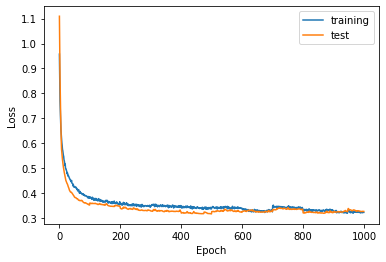

In [15]:
# Training Curve
plt.clf()
plt.plot(lossTrain, label='training')
plt.plot(lossTest, label='test')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("loss.pdf")

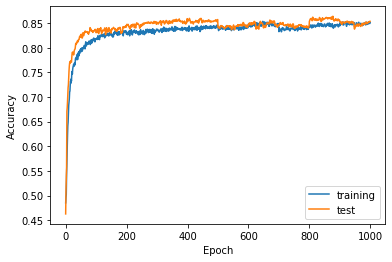

In [16]:
plt.clf()
plt.plot(accTrain, label='training')
plt.plot(accTest, label='test')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("accuracy.pdf")

In [17]:
# Save the model
per.save("simplePer.h5")